In [1]:
import pandas as pd

In [2]:
# load HP data
hp = pd.read_excel('../Data/hp.xlsx')

# Filter for relevant teams
relevant_teams = ['Q9', 'OUG', 'SPG', 'XROCK', 'GodL', 'Wolves']

hp = hp[hp['Team1'].isin(relevant_teams) | hp['Team2'].isin(relevant_teams)]

hp.tail()

,Date,League,Map,Team1,Team2,Hill,RotateFirst,RotationWin,HoldDuration,BreakTeam,BreakSuccess,BreakDuration,PossessionChanges,ScrapTeam,ScrapTime,Score
646,2025-09-11,CDM,Hacienda,Q9,OUG,P1,Q9,No,6,OUG,No,2,4,OUG,3,182-154
647,2025-09-11,CDM,Hacienda,Q9,OUG,P2,OUG,No,14,Q9,No,1,5,Q9,10,210-170
648,2025-09-11,CDM,Hacienda,Q9,OUG,P3,OUG,No,12,Q9,Yes,25,1,Q9,6,235-182
649,2025-09-11,CDM,Hacienda,Q9,OUG,P4,OUG,Yes,48,Q9,No,0,0,OUG,9,235-230
650,2025-09-11,CDM,Hacienda,Q9,OUG,P1,OUG,No,12,Q9,No,1,4,NaN,10,238-250


,Date,League,Map,Team1,Team2,Hill,RotateFirst,RotationWin,HoldDuration,BreakTeam,BreakSuccess,BreakDuration,PossessionChanges,ScrapTeam,ScrapTime,Score
638,2025-09-11,CDM,Hacienda,Q9,OUG,P1,OUG,No,3,Q9,No,1,6,Q9,8,27-16
639,2025-09-11,CDM,Hacienda,Q9,OUG,P2,OUG,No,1,Q9,No,8,6,Q9,9,51-33
640,2025-09-11,CDM,Hacienda,Q9,OUG,P3,OUG,Yes,36,Q9,No,8,1,Q9,5,59-69
641,2025-09-11,CDM,Hacienda,Q9,OUG,P4,OUG,Yes,17,Q9,Yes,18,1,OUG,3,77-89
642,2025-09-11,CDM,Hacienda,Q9,OUG,P1,OUG,No,8,Q9,No,7,3,Q9,6,100-101
643,2025-09-11,CDM,Hacienda,Q9,OUG,P2,OUG,No,12,Q9,No,9,3,Q9,10,131-114
644,2025-09-11,CDM,Hacienda,Q9,OUG,P3,Q9,No,1,OUG,No,2,5,OUG,3,142-124
645,2025-09-11,CDM,Hacienda,Q9,OUG,P4,Q9,Yes,15,OUG,Yes,15,2,Q9,4,167-139
646,2025-09-11,CDM,Hacienda,Q9,OUG,P1,Q9,No,6,OUG,No,2,4,OUG,3,182-154
647,2025-09-11,CDM,Hacienda,Q9,OUG,P2,OUG,No,14,Q9,No,1,5,Q9,10,210-170


In [3]:
# Create new rotation win with partial points
def determine_rotation_win(row):
    if row['HoldDuration'] >= 15:
        return 1
    elif row['HoldDuration'] >= 8:
        return 0.5
    else:
        return 0

def determine_break_success(row):
    if row['BreakDuration'] >= 15:
        return 1
    elif row['BreakDuration'] >= 8:
        return 0.5
    else:
        return 0    
hp['RotationWinPartial'] = hp.apply(determine_rotation_win, axis=1)
hp['BreakSuccessPartial'] = hp.apply(determine_break_success, axis=1)

In [8]:
# Calculate CDL Rotation Win Rate and Break Success Rate for Each Team
team_stats = []

for team in relevant_teams:
    played = hp[(hp['Team1'] == team) | (hp['Team2'] == team)]
    # Rotation Win Rate
    rot_rate = len(played[played['RotateFirst'] == team]) / len(played)
    # Break Success Rate
    break_rate = len(played[played['BreakTeam'] == team]) / len(played)

    team_stats.append({
        'Team': team,
        'RotationWinRateCDL': rot_rate,
        'BreakSuccessRateCDL': break_rate
    })

team_stats_df = pd.DataFrame(team_stats)
display(team_stats_df)

,Team,RotationWinRateCDL,BreakSuccessRateCDL
0,Q9,0.438017,0.561983
1,OUG,0.524823,0.475177
2,SPG,0.561404,0.438596
3,XROCK,0.443548,0.556452
4,GodL,0.540000,0.460000
5,Wolves,0.524752,0.475248


In [14]:
# Parse Score into numeric columns
hp[['Score1', 'Score2']] = hp['Score'].str.split('-', expand=True).astype(int)

# Compute points per hill for each team
hp['Points1'] = hp.groupby(['Date','Map','Team1','Team2'])['Score1'].diff().fillna(hp['Score1'])
hp['Points2'] = hp.groupby(['Date','Map','Team1','Team2'])['Score2'].diff().fillna(hp['Score2'])

# Keep the original row order in a column
hp = hp.reset_index().rename(columns={'index':'OrigRow'})

rotation_rows = []
for (date, map_, t1, t2), group in hp.groupby(['Date', 'Map', 'Team1', 'Team2']):
    # ensure sequential order is preserved
    group = group.reset_index(drop=True)

    # Get scores after first set of hills
    last_row = group[group['Hill'] == 'P4'].head(1)
    if last_row.empty:
        continue

    score1_last = last_row.iloc[0]['Score1']
    score2_last = last_row.iloc[0]['Score2']

    # Determine map winner
    final_row = group[(group['Score1'] == 250) | (group['Score2'] == 250)].head(1)
    if final_row.empty:
        continue

    if final_row.iloc[0]['Score1'] == 250:
        winner = t1
        loser = t2
        target = 1 # from team1's perspective

    else:
        winner = t2
        loser = t1
        target = 0

    # Final Score difference
    if winner == t1:
        score_diff = final_row.iloc[0]['Score1'] - final_row.iloc[0]['Score2']
    else:
        score_diff = final_row.iloc[0]['Score2'] - final_row.iloc[0]['Score1']
    
    rotation_rows.append({
        'Map': map_,
        'Team1': t1,
        'Team2': t2,
        'Score1_P4': score1_last,
        'Score2_P4': score2_last,
        'ScoreDiff_P4': score1_last - score2_last,
        'Winner': winner,
        'Loser': loser,
        'Target_T1': target,
        'FinalScoreDiff': score_diff,
    })

hp_model_df = pd.DataFrame(rotation_rows)
# Calculate match winrate for each team
team_wins = hp_model_df.groupby('Winner').size()
team_total_matches = hp_model_df.groupby('Team1').size() + hp_model_df.groupby('Team2').size()
team_total_matches.dropna(inplace=True)

team_winrate = (team_wins / team_total_matches).reset_index()
team_winrate = team_winrate.rename(columns={0: 'WinRate', 'index': 'Team'})
team_winrate = team_winrate[team_winrate['Team'].isin(relevant_teams)]

display(team_winrate)

,Team,WinRate
0,GodL,0.600000
1,OUG,0.800000
2,Q9,0.538462
3,SPG,0.333333
6,Wolves,0.818182
7,XROCK,0.153846


In [15]:
# Merge with team stats
team_stats_df = team_stats_df.merge(team_winrate, on='Team', how='left')

display(team_stats_df)

,Team,RotationWinRateCDL,BreakSuccessRateCDL,WinRate
0,Q9,0.438017,0.561983,0.538462
1,OUG,0.524823,0.475177,0.800000
2,SPG,0.561404,0.438596,0.333333
3,XROCK,0.443548,0.556452,0.153846
4,GodL,0.540000,0.460000,0.600000
5,Wolves,0.524752,0.475248,0.818182


Text(0.5, 1.0, 'Correlation Matrix')

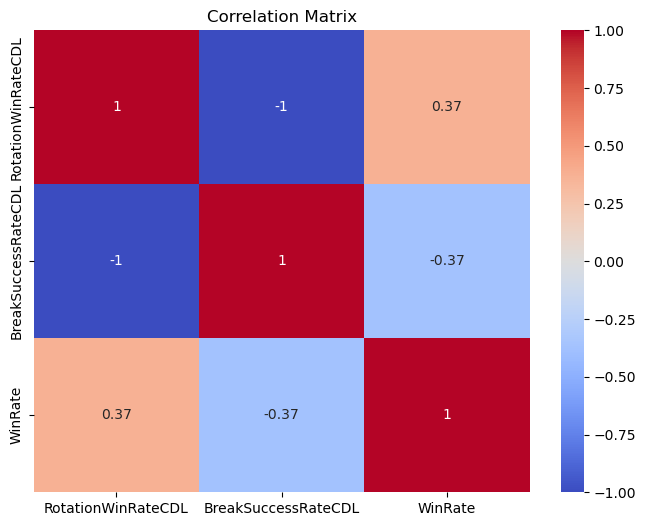

In [16]:
# Correlation matrix
corr_matrix = team_stats_df[['RotationWinRateCDL', 'BreakSuccessRateCDL', 'WinRate']].corr()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')

In [69]:
# Filter for maps
maps = ['Combine', 'Slums', 'Apocalypse']

hp_filtered = hp[hp['Map'].isin(maps)]

hp_filtered

,Date,Map,Team1,Team2,Hill,RotateFirst,RotationWin,HoldDuration,BreakTeam,BreakSuccess,BreakDuration,PossessionChanges,ScrapTeam,ScrapTime,Score,RotationWinPartial,BreakSuccessPartial
28,2025-07-31,Combine,Q9,SPG,P1,Q9,No,2,SPG,No,5,4,Q9,7,27-7,0.0,0.0
29,2025-07-31,Combine,Q9,SPG,P2,Q9,Yes,41,SPG,No,6,3,Q9,6,70-14,1.0,0.0
30,2025-07-31,Combine,Q9,SPG,P3,SPG,No,2,Q9,No,4,3,Q9,10,91-47,0.0,0.0
31,2025-07-31,Combine,Q9,SPG,P4,Q9,No,1,SPG,No,14,3,Q9,8,112-70,0.0,0.5
32,2025-07-31,Combine,Q9,SPG,P1,SPG,No,6,Q9,Yes,18,2,Q9,7,138-80,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,2025-08-23,Apocalypse,OUG,Q9,P1,Q9,Yes,15,OUG,No,3,4,Q9,4,103-132,1.0,0.0
422,2025-08-23,Apocalypse,OUG,Q9,P2,Q9,No,6,OUG,No,13,3,OUG,6,138-147,0.0,0.5
423,2025-08-23,Apocalypse,OUG,Q9,P3,OUG,No,2,Q9,No,3,2,Q9,7,177-156,0.0,0.0
424,2025-08-23,Apocalypse,OUG,Q9,P4,OUG,No,13,Q9,No,10,3,Q9,10,207-178,0.5,0.5


In [70]:
# Successful rotations + breaks
rot_wins = hp_filtered[hp_filtered['RotationWin'] == 'Yes']
break_success = hp_filtered[hp_filtered['BreakSuccess'] == 'Yes']

print(f"Rotation Win Rate: {(hp_filtered['RotationWinPartial'].sum()/ len(hp_filtered) * 100):.2f}")

print(f"Break Success Rate: {(hp_filtered['BreakSuccessPartial'].sum()/ len(hp_filtered) * 100):.2f}")

Rotation Win Rate: 50.00
Break Success Rate: 41.33


In [71]:
# Average Possession Changes
avg_possession_changes = hp_filtered['PossessionChanges'].mean()

print(f"Average Possession Changes: {avg_possession_changes:.2f}")

Average Possession Changes: 2.32


In [73]:
# Load in HP data again
hp_garena = pd.read_excel('../Data/hp.xlsx')

# Filter for Garena teams
garena_teams = ['STE', 'ELV']

hp_garena = hp_garena[hp_garena['Team1'].isin(garena_teams) | hp_garena['Team2'].isin(garena_teams)]
hp_garena['RotationWinPartial'] = hp_garena.apply(determine_rotation_win, axis=1)
hp_garena['BreakSuccessPartial'] = hp_garena.apply(determine_break_success, axis=1)
hp_garena.head()

,Date,Map,Team1,Team2,Hill,RotateFirst,RotationWin,HoldDuration,BreakTeam,BreakSuccess,BreakDuration,PossessionChanges,ScrapTeam,ScrapTime,Score,RotationWinPartial,BreakSuccessPartial
426,2025-08-24,Combine,STE,ELV,P1,STE,No,8,ELV,No,4,6,STE,4,16-12,0.5,0.0
427,2025-08-24,Combine,STE,ELV,P2,STE,No,3,ELV,No,13,2,ELV,5,48-30,0.0,0.5
428,2025-08-24,Combine,STE,ELV,P3,STE,No,8,ELV,No,1,6,STE,10,77-41,0.5,0.0
429,2025-08-24,Combine,STE,ELV,P4,ELV,No,8,STE,No,3,5,STE,8,107-52,0.5,0.0
430,2025-08-24,Combine,STE,ELV,P1,ELV,No,10,STE,No,5,4,STE,4,122-71,0.5,0.0


In [74]:
# Successful rotations + breaks for Garena teams
rot_wins_garena = hp_garena[hp_garena['RotationWin'] == 'Yes']
break_success_garena = hp_garena[hp_garena['BreakSuccess'] == 'Yes']

# Group by team and calculate win rates
rot_win_rate_garena = hp_garena.groupby('RotateFirst')['RotationWinPartial'].mean() * 100
break_success_rate_garena = hp_garena.groupby('BreakTeam')['BreakSuccessPartial'].mean() * 100

print("Garena Rotation Win Rates:")
print(rot_win_rate_garena)

print("Garena Break Success Rates:")
print(break_success_rate_garena)

Garena Rotation Win Rates:
RotateFirst
ELV    45.000000
STE    40.909091
Name: RotationWinPartial, dtype: float64
Garena Break Success Rates:
BreakTeam
ELV    31.818182
STE    25.000000
Name: BreakSuccessPartial, dtype: float64


In [75]:
# Average Possession Changes for Garena teams
avg_possession_changes_garena = hp_garena['PossessionChanges'].mean()
print(f"Garena Average Possession Changes: {avg_possession_changes_garena:.2f}")

Garena Average Possession Changes: 3.32


In [76]:
# Compare Garena data with Wolves vs. OUG
wol_oug = hp[(hp['Team1'].isin(['Wolves', 'OUG', 'GodL'])) & (hp['Team2'].isin(['Wolves', 'OUG', 'GodL']))]

# # Successful rotations + breaks for Wolves vs. OUG
# rot_wins_wol_oug = wol_oug[wol_oug['RotationWin'] == 'Yes']
# break_success_wol_oug = wol_oug[wol_oug['BreakSuccess'] == 'Yes']

# Group by team and calculate win rates
rot_win_rate_wol_oug = wol_oug.groupby('RotateFirst')['RotationWinPartial'].mean() * 100
break_success_rate_wol_oug = wol_oug.groupby('BreakTeam')['BreakSuccessPartial'].mean() * 100
print("Wolves vs. OUG Rotation Win Rates:")
print(rot_win_rate_wol_oug)

print("Wolves vs. OUG Break Success Rates:")
print(break_success_rate_wol_oug)

Wolves vs. OUG Rotation Win Rates:
RotateFirst
GodL      68.750000
OUG       52.941176
Wolves    58.333333
Name: RotationWinPartial, dtype: float64
Wolves vs. OUG Break Success Rates:
BreakTeam
GodL      29.166667
OUG       50.000000
Wolves    46.666667
Name: BreakSuccessPartial, dtype: float64
